<a href="https://colab.research.google.com/github/belovelace/AI-study/blob/main/WISDM_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from tensorflow.keras.layers import Multiply

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, InputLayer, Dropout, Flatten, BatchNormalization, Conv1D
from tensorflow.keras.layers import concatenate
from keras.utils import to_categorical
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
from sklearn.metrics import confusion_matrix, classification_report


# Import necessary layers for the CNN-Transformer model
from tensorflow.keras.layers import Conv2D, MultiHeadAttention, LayerNormalization, Add, Reshape, GlobalAveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

In [2]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

df = pd.read_csv("/content/drive/MyDrive/AI_study/WISDM_ar_v1.1_raw.txt",
                 header=None,
                 sep=',',
                 names=['user', 'activity', 'timestamp', 'x', 'y', 'z'],
                 on_bad_lines='skip')

Mounted at /content/drive


In [3]:
df['z'] = df['z'].astype(str).str.replace(';', '').str.strip()

# 결측값 제거
df = df.dropna()

print(f"데이터 로딩 완료: {df.shape}")
df.head()

데이터 로딩 완료: (1086466, 6)


,user,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [4]:
label=LabelEncoder()
df['activity']=label.fit_transform(df['activity'])
df

,user,activity,timestamp,x,y,z
0,33,1,49105962326000,-0.694638,12.680544,0.50395286
1,33,1,49106062271000,5.012288,11.264028,0.95342433
2,33,1,49106112167000,4.903325,10.882658,-0.08172209
3,33,1,49106222305000,-0.612916,18.496431,3.0237172
4,33,1,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1086461,19,2,131623331483000,9.000000,-1.570000,1.69
1086462,19,2,131623371431000,9.040000,-1.460000,1.73
1086463,19,2,131623411592000,9.080000,-1.380000,1.69
1086464,19,2,131623491487000,9.000000,-1.460000,1.73


In [5]:
df['x'] = df['x'].astype('float')
df['y'] = df['y'].astype('float')
df['z'] = df['z'].astype('float')

In [6]:
users=sorted(df['user'].unique())
print(users)

[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36)]


In [7]:
#train, test 분리
train_users=[u for u in users if u<=28]
val_users=[u for u in users if 2832]
test_users=[u for u in users if u>32]

#사용자 그룹에 따라 DataFrame 생성
train_df = df[df['user'].isin(train_users)].copy()
test_df  = df[df['user'].isin(test_users)].copy()
val_df=df[df['user'].isin(val_users)].copy()

# NaN 값 제거
train_df = train_df.dropna()
val_df = val_df.dropna()
test_df = test_df.dropna()


print("======데이터 분할(사용자 기반)=====")
print(f"훈련용 사용자 수: {len(train_users)}명, 데이터 수: {len(train_df)}")
print(f"검증용 사용자 수: {len(val_users)}명, 데이터 수: {len(val_df)}")
print(f"테스트용 사용자 수: {len(test_users)}명, 데이터 수: {len(test_df)}")

======데이터 분할(사용자 기반)=====
훈련용 사용자 수: 28명, 데이터 수: 823043
검증용 사용자 수: 36명, 데이터 수: 1086465
테스트용 사용자 수: 4명, 데이터 수: 120055


In [8]:
# Define the features to be scaled
features = ['x', 'y', 'z']

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform all dataframes
scaler.fit(train_df[features])        # 훈련 데이터로만 학습
train_df[features] = scaler.transform(train_df[features])  # 동일 기준 적용
val_df[features] = scaler.transform(val_df[features])      # 동일 기준 적용
test_df[features] = scaler.transform(test_df[features])    # 동일 기준 적용

print("데이터 스케일링 완료")

데이터 스케일링 완료


In [9]:
def segments(df, time_steps, step, label_name):
    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x'].values[i:i+time_steps]
        ys = df['y'].values[i:i+time_steps]
        zs = df['z'].values[i:i+time_steps]

        win_labels = df[label_name].values[i:i+time_steps].astype(int)
        label = np.bincount(win_labels).argmax()
        segments.append([xs, ys, zs])
        labels.append(label)

    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [10]:
TIME_PERIOD = 80
STEP_DISTANCE = 40
LABEL = 'activity'

In [11]:

train_df = train_df.dropna()
val_df = val_df.dropna()
test_df = test_df.dropna()

In [12]:

#훈련 데이터셋
x_train, y_train=segments(train_df, TIME_PERIOD, STEP_DISTANCE, LABEL)

#검증 데이터셋
x_val, y_val=segments(val_df, TIME_PERIOD, STEP_DISTANCE, LABEL)

#테스트 데이터셋
x_test, y_test=segments(test_df, TIME_PERIOD, STEP_DISTANCE, LABEL)

#원핫인코딩
from tensorflow.keras.utils import to_categorical

num_classes=label.classes_.size
y_train_hot=to_categorical(y_train, num_classes)
y_val_hot=to_categorical(y_val, num_classes)
y_test_hot=to_categorical(y_test, num_classes)

# x_train = x_train / np.max(np.abs(x_train)) # 이 부분 제거
# x_val = x_val / np.max(np.abs(x_val)) # 이 부분 제거

print("훈련 데이터:", x_train.shape, y_train_hot.shape)
print("검증 데이터", x_val.shape, y_val_hot.shape)

print("====================================")

x_train = x_train.reshape(x_train.shape[0], TIME_PERIOD, 3, 1) # 제거
x_val = x_val.reshape(x_val.shape[0], TIME_PERIOD, 3, 1) # 제거
x_test = x_test.reshape(x_test.shape[0], TIME_PERIOD, 3, 1) # 제거

x_train.shape, x_val.shape

훈련 데이터: (20575, 80, 3) (20575, 6)
검증 데이터 (27160, 80, 3) (27160, 6)


((20575, 80, 3, 1), (27160, 80, 3, 1))

### CNN

In [13]:
model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = (TIME_PERIOD,3,1)))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation="softmax"))


model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 79, 2, 16)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 79, 2, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 78, 1, 32)      │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 78, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2496)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       159,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,358 (634.21 KB)

 Trainable params: 162,358 (634.21 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
optimizer=Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
from sklearn.utils import class_weight
class_weights=class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict=dict(enumerate(class_weights))

early_stop=EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


history=model.fit(
    x_train, y_train_hot,
    epochs=50,
    batch_size=32,
    validation_data=(x_val, y_val_hot),
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)

Epoch 1/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.4686 - loss: 1.3948 - val_accuracy: 0.7346 - val_loss: 0.8167
Epoch 2/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6687 - loss: 0.7795 - val_accuracy: 0.7667 - val_loss: 0.6912
Epoch 3/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6983 - loss: 0.6832 - val_accuracy: 0.7823 - val_loss: 0.6330
Epoch 4/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7384 - loss: 0.6293 - val_accuracy: 0.7812 - val_loss: 0.6347
Epoch 5/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7449 - loss: 0.6099 - val_accuracy: 0.8018 - val_loss: 0.5961
Epoch 6/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7732 - loss: 0.5609 - val_accuracy: 0.8125 - val_loss: 0.5636
Epoch 7/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7828 - loss: 0.5567 - val_accuracy: 0.8141 - val_loss: 0.5823
Epoch 8/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7887 - loss: 0.5255 - val_accuracy: 

In [16]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epochs_run = len(history.history['loss'])
  epoch_range = range(1, epochs_run+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

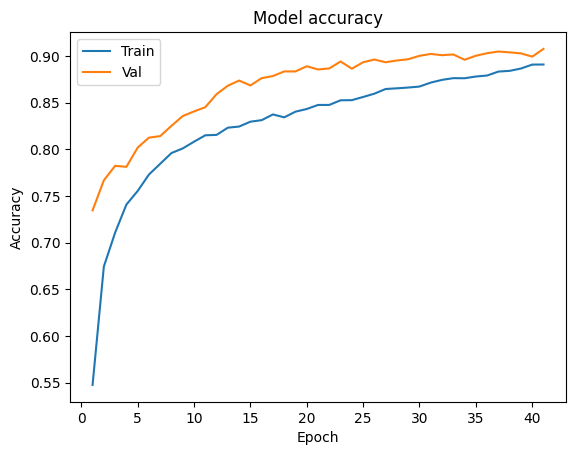

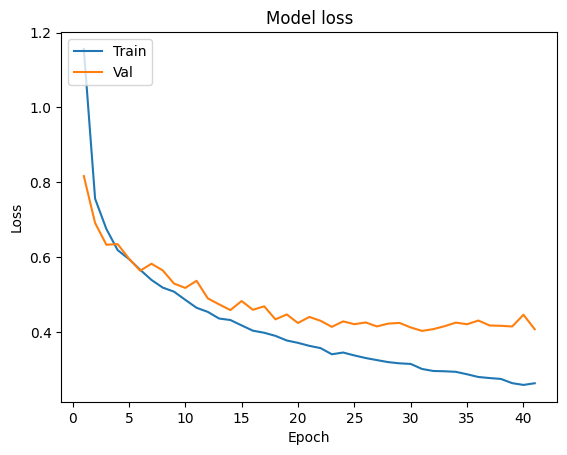

In [17]:
plot_learningCurve(history, 10)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


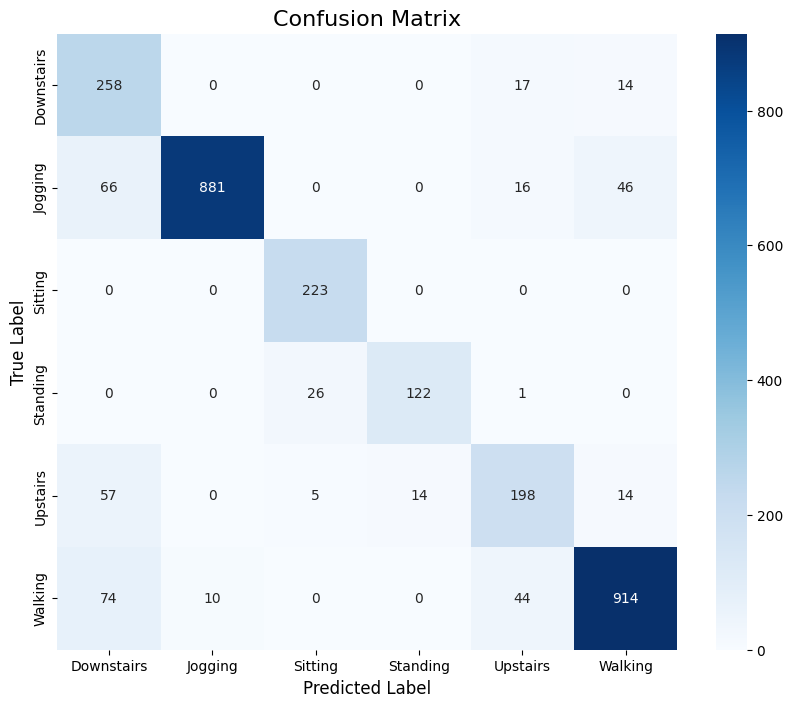

In [18]:
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

#혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)

#시각화
plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label.classes_, yticklabels=label.classes_)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

In [19]:
loss, accuracy = model.evaluate(x_test, y_test_hot, verbose=0)
print("="*30)
print(f"테스트 데이터 정확도 (Accuracy): {accuracy:.4f}")
print(f"테스트 데이터 손실 (Loss): {loss:.4f}")
print("="*30)


테스트 데이터 정확도 (Accuracy): 0.8653
테스트 데이터 손실 (Loss): 0.5207


In [20]:
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\n===== 분류 리포트 =====")
print(classification_report(y_test, y_pred, target_names=label.classes_))

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

===== 분류 리포트 =====
              precision    recall  f1-score   support

  Downstairs       0.57      0.89      0.69       289
     Jogging       0.99      0.87      0.93      1009
     Sitting       0.88      1.00      0.94       223
    Standing       0.90      0.82      0.86       149
    Upstairs       0.72      0.69      0.70       288
     Walking       0.93      0.88      0.90      1042

    accuracy                           0.87      3000
   macro avg       0.83      0.86      0.84      3000
weighted avg       0.89      0.87      0.87      3000

